In [11]:
import numpy as np
import cfgrib
import xarray as xr
#import xesmf as xe

import xarray as xr
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime
import pandas as pd
import geopandas as gp

# Probablity

## convert grib into netcdf following sf method

In [ ]:
#based on https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
month_list=['Month1.grib','Month2.grib','Month3.grib','Month4.grib','Month5.grib','Month6.grib']

for mnl in month_list:
    ds_out = xr.Dataset(
    {"lat": (["lat"], np.arange(-2, 5.25, 0.25), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(29, 38.25, 0.25), {"units": "degrees_east"}),})
    gd1 = xr.open_dataset(mnl, engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
    gd1['latitude'].values,gd1['longitude'].values
    gd2=gd1.rename({'longitude':'lon','latitude':'lat'})
    agd = gd2["tprate"]
    regridder = xe.Regridder(gd2, ds_out, "bilinear")
    dr_out = regridder(agd, keep_attrs=True)
    ds2=dr_out.to_dataset()
    monthname=mnl.lower().split('.')[0]
    ds2.to_netcdf(f'/home/kmj_seas5/kmj_lt{monthname}_km25_seas5_mem0.nc')
    ds_out=[]
    gd1=[]
    gd2=[]
    regridder=[]
    dr_out=[]
    ds2=[]
    print(monthname)

## convert total perceipation/second into per month

In [ ]:
month_list=['month1','month2','month3','month4','month5','month6']


for mnth in month_list:
    db=xr.open_dataset(f'/home/kmj_seas5/kmj_lt{mnth}_km25_seas5_mem0.nc')
    #vd_t = for kmon in pd.to_datetime(db.time.values) + relativedelta(months=1)
    #db = db.assign_coords(valid_time=('forecastMonth',vd_t))
    #db 
    mnth_int=int(re.findall(r'\d+', mnth)[0])
    aa=pd.to_datetime(db.time.values)
    cont_vdt=[]
    for itu in aa:
        #print(itu)
        vd_t=itu+relativedelta(months=mnth_int-1)
        #print('#########')
        cont_vdt.append(vd_t)
    db = db.assign_coords(valid_time=('time',cont_vdt))
    numdays = [monthrange(dd.year,dd.month)[1] for dd in cont_vdt]
    db = db.assign_coords(numdays=('time',numdays))
    db = db * db.numdays * 24 * 60 * 60 * 1000
    db.attrs['units'] = 'mm/month'
    db.attrs['long_name'] = 'Total precipitation' 
    db.to_netcdf(f'/home/kmj_seas5/tp_kmj_lt{mnth}_km25_seas5_mem51.nc')
    db=[]
    aa=[]
    cont_vdt=[]
    numdays=[]

## Join multi month forecast into single composite product

1. Jan, Feb, Mar, Apr, May, Nov, Dec composite products

In [ ]:
dates = pd.date_range('1993-01-01', '2022-10-01', freq='MS')
#db=pd.DataFrame(dates)
#db.columns=['years']
#db1=db.set_index('years')
#db1[db1.index.month.isin([12])]

jan_dates=dates[dates.month.isin([1])]
jd1=jan_dates.strftime('%Y-%m-%dT00:00:00.000000000')

month_list=['month1','month2','month3','month4','month5','month6']


#for month in month_list:
jan_dates=dates[dates.month.isin([1])]
jd1=jan_dates.strftime('%Y-%m-%dT00:00:00.000000000')


cont_mdb=[]
for jd in jd1:
    db_m1=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth1_km25_seas5_mem51.nc')
    db1_m1=db_m1.sel(time=jd)
    db_m2=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth2_km25_seas5_mem51.nc')
    db1_m2=db_m2.sel(time=jd)
    db_m3=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth3_km25_seas5_mem51.nc')
    db1_m3=db_m3.sel(time=jd)
    db_m4=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth4_km25_seas5_mem51.nc')
    db1_m4=db_m4.sel(time=jd)
    db_m5=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth5_km25_seas5_mem51.nc')
    db1_m5=db_m5.sel(time=jd)
    db_m6=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth6_km25_seas5_mem51.nc')
    db1_m6=db_m6.sel(time=jd)
    db1_m=xr.concat([db1_m1,db1_m2,db1_m3,db1_m4,db1_m5,db1_m6],dim='time')
    cont_mdb.append(db1_m)
    
    
erf1=xr.concat(cont_mdb,dim='time')
#erf['time'].values[4],erf['valid_time'].values[4]
#erf['valid_time'].values
#erf1=erf.rename({'time': 'old_time','valid_time': 'time'})
#erf2=erf1.drop("time")
#erf2.assign_coords({"time": erf2.valid_time.values})
#erf1['time'].values
#erf3 = erf2.expand_dims(time=erf2.valid_time.values)
#erf3['time'].values
erf1 = erf1.assign_coords(time=('time',erf1.valid_time.values))
#erf1['time'].values

erf1.to_netcdf('/home/kmj_seas5/trail2/jan_1993.nc')

## SPI calculation 

In [ ]:
# based on https://gist.github.com/monocongo/978348233b4bde80e9bcc52fe8e4150c
from typing import Dict
from climate_indices.indices import spi, Distribution
from climate_indices.compute import Periodicity
import numpy as np
import pandas as pd
import requests
import xarray as xr


# create a wrapper function that can be applied to an entire Dataset
# (takes a DataArray as first argument, returns a DataArray)
def spi_wrapper(
    obj: xr.DataArray,
    precip_var: str,
    scale: int,
    distribution: Distribution,
    data_start_year: int,
    calibration_year_initial: int,
    calibration_year_final: int,
    periodicity: Periodicity,
    fitting_params: Dict = None,
) -> xr.DataArray:
    
    # compute SPI for this timeseries
    spi_data = spi(
        values=obj[precip_var].to_numpy(), #TODO find why we need to use the variable name rather than already using the variables's DataArray (i.e. why is obj a Dataset?)
        scale=scale,
        distribution=distribution,
        data_start_year=data_start_year,
        calibration_year_initial=calibration_year_initial,
        calibration_year_final=calibration_year_final,
        periodicity=periodicity,
        fitting_params=fitting_params,
    )
    #TODO for some reason this is necessary for the nClimGrid low-resolution example NetCDFs
    #TODO find out why
    spi_data = spi_data.flatten()
    #TODO for some reason this is necessary for the NCO-modified nClimGrid normal-resolution example NetCDFs
    #TODO find out why
    #spi_data = spi_data.reshape(spi_data.size, 1)
    # create the return DataArray (copy of input object's geospatial dims/coords plus SPI data)
    da_spi = xr.DataArray(
        dims   = obj[precip_var].dims,
        coords = obj[precip_var].coords,
        attrs  = {
            'description': 'SPI computed by the climate_indices Python package',
            'references': 'https://github.com/monocongo/climate_indices',
            'valid_min': -3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MIN
            'valid_max':  3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MAX
        },
        data = spi_data,
    )

    return da_spi

In [ ]:
import xarray as xr

sdb=xr.open_dataset('/home/kmj_seas5/trail2/jan_1993.nc')


member_list=np.arange(0,51,1)


for meml in member_list:
    #sdb1=sdb['tprate'][meml]
    #sdb2=sdb1.to_dataset(name='tprate')
    sdb1=sdb.sel(number=meml)
    #sdb2
    sc = sdb1.stack(grid_cells=('lat', 'lon',))
    spi_ds = sc.groupby('grid_cells').apply(
        spi_wrapper,
        precip_var='tprate',
        scale=3,
        distribution=Distribution.gamma,
        data_start_year=1993,
        calibration_year_initial=1993,
        calibration_year_final=2018,
        periodicity=Periodicity.monthly).unstack('grid_cells')
    spi_ds1=spi_ds.to_dataset(name='tprate')
    #spi_ds2=spi_ds1.to_dataframe()
    #db3=db2.reset_index()
    #spi_ds3=spi_ds2.reset_index()
    output_path='/home/kmj_seas5/trail2/spi_jan_1993_3/'
    #spi_ds2.to_csv(f'{output_path}month6_{meml}.csv')
    spi_ds1.to_netcdf(f'{output_path}jan_{meml}.nc')
    sdb1=[]
    sdb2=[]
    sc=[]
    spi_ds=[]
    spi_ds1=[]
    spi_ds2=[]
    spi_ds3=[]
    print(meml)

## exceedance probablities 

In [134]:

def excprob(X, X_thr, ignore_nan=False):
    """
    For a given forecast ensemble field, compute exceedance probabilities
    for the given intensity thresholds.
    Parameters
    ----------
    X: array_like
        Array of shape (k, m, n, ...) containing an k-member ensemble of
        forecasts with shape (m, n, ...).
    X_thr: float or a sequence of floats
        Intensity threshold(s) for which the exceedance probabilities are
        computed.
    ignore_nan: bool
        If True, ignore nan values.
    Returns
    -------
    out: ndarray
        Array of shape (len(X_thr), m, n) containing the exceedance
        probabilities for the given intensity thresholds.
        If len(X_thr)=1, the first dimension is dropped.
        
    https://github.com/pySTEPS/pysteps/blob/master/pysteps/postprocessing/ensemblestats.py
    """
    #  Checks
    X = np.asanyarray(X)
    X_ndim = X.ndim

    if X_ndim < 3:
        raise Exception(
            f"Number of dimensions of X should be 3 or more. It was: {X_ndim}"
        )

    P = []

    if np.isscalar(X_thr):
        X_thr = [X_thr]
        scalar_thr = True
    else:
        scalar_thr = False

    for x in X_thr:
        X_ = X.copy()
        #original
        #X_[X >= x] = 1.0
        #X_[X < x] = 0.0
        #changes to make less than threnshold
        X_[X <= x] = 1.0
        X_[X > x] = 0.0
        X_[~np.isfinite(X)] = np.nan

        if ignore_nan:
            P.append(np.nanmean(X_, axis=0))
        else:
            P.append(np.mean(X_, axis=0))

    if not scalar_thr:
        return np.stack(P)
    else:
        return P[0]



In [135]:
member_list=np.arange(0,51,1)

mam_ncfl_path='/home/kmj_seas5/trail2/spi_jan_1993_3/'


mem_data_arrays = []
for mem in member_list:
    mem_file_path=f'{mam_ncfl_path}jan_{mem}.nc'
    ds=xr.open_dataset(mem_file_path)
    mem_data_arrays.append(ds)
    ds=[]
# concatenate list of data arrays along new dimension into xarray dataset
ds_ens = xr.concat(mem_data_arrays, dim='ens_mem')


## adding spi product axis to filter it 

In [136]:
db=pd.DataFrame()
db['dt']=ds_ens['time'].values
db['month']=db['dt'].dt.strftime('%b').astype(str).str[0]
db['year']=db['dt'].dt.strftime('%Y')
db['spi_prod'] = db.groupby('year')['month'].shift(2)+db.groupby('year')['month'].shift(1) + db.groupby('year')['month'].shift(0)
spi_prod_list=db['spi_prod'].tolist()
spi_prod_list

[nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MAM',
 'AMJ',
 nan,
 nan,
 'JFM',
 'FMA',
 'MA

In [137]:
ds_ens1 = ds_ens.assign_coords(spi_prod=('time',spi_prod_list))
#ds_ens2=ds_ens[ds_ens['spi_prod']=='MAM']

#db1_m1=ds_ens1.sel(spi_prod='MAM')

spi_ds_ens=ds_ens1.where(ds_ens1.spi_prod=='MAM', drop=True)


## subset with lat long for kmj region
https://stackoverflow.com/questions/74197804/how-to-remove-a-grid-point-in-xarray

In [138]:
kp=gp.read_file('/home/kmj_points.shp')
kp['lon'] = kp.geometry.x
kp1=kp.drop_duplicates('lon')
kp2=kp1.sort_values('lon')
kp2_lon=kp2['lon'].tolist()
kp['lat'] = kp.geometry.y
kp1=kp.drop_duplicates('lat')
kp2=kp1.sort_values('lat')
kp2_lat=kp2['lat'].tolist()


#lon_list=list(set(kp['lon'].tolist())).sort()
#lat_list=list(set(kp['lat'].tolist())).sort()


xda = xr.DataArray(kp2_lon, dims=['z'])
yda = xr.DataArray(kp2_lat, dims=['z'])

#aa1=aa.sel(:,lat=yda, lon=xda)
#aa1
#LatIndexer, LonIndexer = 'lat', 'lon'
#aa1 = aa.sel(**{LatIndexer: slice(4.25, 1.5),
#                        LonIndexer: slice(35.0, 33.5)})

#LatIndexer, LonIndexer = 'lat', 'lon'
#SliceData = aa.loc[{LatIndexer: slice(4.25, 1.5),
#                      LonIndexer: slice(35.0, 33.5)}]
#aa

spi_ds_ens_kmj = spi_ds_ens.sel(lat=slice(min(kp2_lat),max(kp2_lat)), lon=slice(min(kp2_lon),max(kp2_lon)))
spi_ds_ens_kmj_st=spi_ds_ens_kmj.sel(time='1993-05-01T00:00:00.000000000')
pro_ds=excprob(spi_ds_ens_kmj_st.to_array(), [-0.03, -0.55,-0.99], ignore_nan=False)

In [139]:
dates = pd.date_range('1993-01-01', '2022-10-01', freq='MS')
#db=pd.DataFrame(dates)
#db.columns=['years']
#db1=db.set_index('years')
#db1[db1.index.month.isin([12])]

#jan_dates=dates[dates.month.isin([1])]
#jd1=jan_dates.strftime('%Y-%m-%dT00:00:00.000000000')
mam_dates=dates[dates.month.isin([5])]
cont_data_xds_mild=[]
cont_data_xds_moderate=[]
cont_data_xds_severe=[]
for dat in mam_dates:
    jd1=dat.strftime('%Y-%m-%dT00:00:00.000000000')
    year=dat.strftime('%Y')
    spi_ds_ens_kmj_st=spi_ds_ens_kmj.sel(time=jd1)
    pro_ds=excprob(spi_ds_ens_kmj_st.to_array(), [-0.03, -0.55,-0.99], ignore_nan=False)
    data_xr = xr.DataArray(pro_ds,coords={'prob':['mild','moderate','severe'],'ens_mem':spi_ds_ens_kmj.ens_mem.values,
        'lat': spi_ds_ens_kmj.lat.values,'lon': spi_ds_ens_kmj.lon.values,'time':year}, 
       dims=["prob", "ens_mem", "lat","lon"])
    data_xds=data_xr.to_dataset(name='prob_exced')
    data_xds_mild=data_xds.sel(prob='mild')
    data_xds_mild1 = data_xds_mild.where(data_xds_mild.prob_exced >=1).sum("ens_mem")/data_xds_mild.where(data_xds_mild.prob_exced.notnull()).count("ens_mem")
    data_xds_moderate=data_xds.sel(prob='moderate')
    data_xds_moderate1 = data_xds_moderate.where(data_xds_moderate.prob_exced >=1).sum("ens_mem")/data_xds_moderate.where(data_xds_moderate.prob_exced.notnull()).count("ens_mem")
    data_xds_severe=data_xds.sel(prob='severe')
    data_xds_severe1 = data_xds_severe.where(data_xds_severe.prob_exced >=1).sum("ens_mem")/data_xds_severe.where(data_xds_severe.prob_exced.notnull()).count("ens_mem")
    year_data_xds=xr.concat([data_xds_mild1,data_xds_moderate1,data_xds_severe1],dim='time')
    cont_data_xds_mild.append(data_xds_mild1)
    cont_data_xds_moderate.append(data_xds_moderate1)
    cont_data_xds_severe.append(data_xds_severe1)
    year_data_xds=[]
    data_xds_severe1 = []
    data_xds_moderate1 = []
    data_xds_mild1 = []
    data_xr=[]
    data_xds=[]

In [140]:
cont_data_xds_mild1=xr.concat(cont_data_xds_mild,dim='time')
cont_data_xds_moderate1=xr.concat(cont_data_xds_moderate,dim='time')
cont_data_xds_severe1=xr.concat(cont_data_xds_severe,dim='time')


In [141]:
cont_data_xds_mild2 = cont_data_xds_mild1.reset_coords(drop=True).to_dataframe()
cont_data_xds_mild3=cont_data_xds_mild2.reset_index()
cont_data_xds_mild4 = cont_data_xds_mild3.groupby(['time'])['prob_exced'].mean().reset_index()
#
cont_data_xds_moderate2 = cont_data_xds_moderate1.reset_coords(drop=True).to_dataframe()
cont_data_xds_moderate3=cont_data_xds_moderate2.reset_index()
cont_data_xds_moderate4 = cont_data_xds_moderate3.groupby(['time'])['prob_exced'].mean().reset_index()
#
cont_data_xds_severe2 = cont_data_xds_severe1.reset_coords(drop=True).to_dataframe()
cont_data_xds_severe3=cont_data_xds_severe2.reset_index()
cont_data_xds_severe4 = cont_data_xds_severe3.groupby(['time'])['prob_exced'].mean().reset_index()
#cont_data_xds_severe4

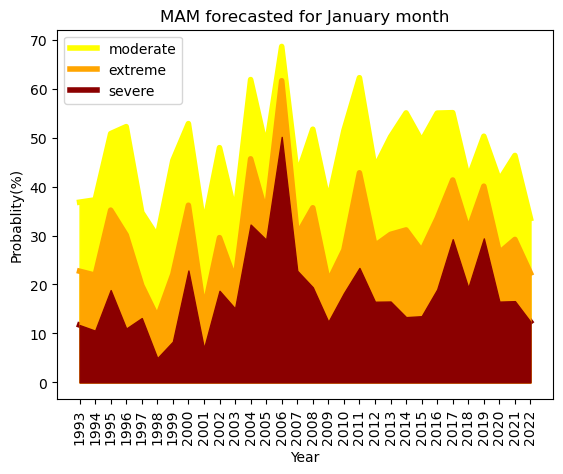

In [144]:
#https://stackoverflow.com/questions/16417496/matplotlib-fill-between-multiple-lines
import numpy as np
import matplotlib.pyplot as plt


year = cont_data_xds_mild1.time.values
population_by_continent = {
    'mild': [i * 100 for i in cont_data_xds_mild4['prob_exced'].tolist()],
    'moderate': [i * 100 for i in cont_data_xds_moderate4['prob_exced'].tolist()],
    'severe': [i * 100 for i in cont_data_xds_severe4['prob_exced'].tolist()]
}

fig, ax = plt.subplots()


ax.plot(year,population_by_continent['mild'],color='#ffff00',lw=4)
ax.plot(year,population_by_continent['moderate'],color='#ffa500',lw=4)
ax.plot(year,population_by_continent['severe'],color='#8b0000',lw=4)

ax.fill_between(year, [0]*len(year),population_by_continent['mild'],color='#ffff00',alpha=1,zorder=0)
ax.fill_between(year, [0]*len(year),population_by_continent['moderate'],color='#ffa500',alpha=1,zorder=5)
ax.fill_between(year, [0]*len(year),population_by_continent['severe'],color='#8b0000',alpha=1,zorder=10)

ax.legend(['moderate','extreme','severe'],loc='upper left')
ax.set_title('MAM forecasted for January month')
ax.set_xlabel('Year')
ax.set_ylabel('Probablity(%)')
plt.xticks(rotation=90)

plt.show()